# Exploratory Data Analysis - Yellow Taxi

In [1]:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set()

In [2]:
path='/Users/zora/Desktop/NYC TAXI/DATA WRANGLING/NYC TAXI DATA'
os.chdir(path)
os.listdir()
df = pd.read_csv('yellow_taxi_09_2019.csv', index_col=0)
df.head()

/Users/zora/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,dropoff_zone,trip_region,trip_time,trip_speed,pickup_hour,dropoff_hour,pickup_day,dropoff_day,month,Type
0,1.0,2019-09-01 00:06:48,2019-09-01 00:25:46,1.0,2.0,1.0,N,186,161,2.0,...,Midtown Center,within_downtown,18.0,0.111111,0,0,Sunday,Sunday,9,yellow
1,1.0,2019-09-01 00:29:17,2019-09-01 00:57:54,1.0,5.5,1.0,N,161,256,2.0,...,Williamsburg (South Side),downtown_boro,28.0,0.196429,0,0,Sunday,Sunday,9,yellow
2,1.0,2019-09-01 00:41:32,2019-09-01 00:41:36,1.0,2.9,1.0,N,145,145,2.0,...,Long Island City/Hunters Point,within_boro,0.0,inf,0,0,Sunday,Sunday,9,yellow
4,1.0,2019-09-01 00:39:41,2019-09-01 00:45:06,1.0,1.5,1.0,N,95,93,2.0,...,Flushing Meadows-Corona Park,within_boro,5.0,0.300000,0,0,Sunday,Sunday,9,yellow
5,1.0,2019-09-01 00:00:08,2019-09-01 00:36:43,2.0,8.3,1.0,N,161,232,1.0,...,Two Bridges/Seward Park,within_downtown,36.0,0.230556,0,0,Sunday,Sunday,9,yellow


In [3]:
print('The dataset has', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataset has 6392735 rows and 33 columns.


## Build data profile tables and plots

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392735 entries, 0 to 6533697
Data columns (total 33 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  pickup_boro            object 
 19  pickup_servicezone     object 
 20  pickup_zone            object 
 21  dropoff_boro           object 
 22  dropoff_servicezon

In [5]:
# Convert the columns to the appropriate types
df = df.astype({'VendorID': object, 'passenger_count': object, 'PULocationID': object, 'DOLocationID': object, 
                'RatecodeID': object, 'payment_type': object}, errors='ignore')
df['tpep_pickup_datetime']=pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime']=pd.to_datetime(df['tpep_dropoff_datetime'])

### Create derived variables for data cleaning

#### Records that met the following criteria were excluded from all subsequent analyses:
- Distance of 0 mile or distance ≥ 50 miles;

- Duration of 0 minute or duration ≥ 200 minutes;

- Average speed ≤ 1 MPH or average speed ≥ 240 MPH;

- Base fare < 2.50 or ≥ 250.00, or tip amount > twice the base fare;

- With invalid longitude or latitude data, or with a trip distance shorter than the geographic distance between pickup and drop-off point by more than 1 mile, or traveled outside the 5 boroughs or 3 airports of NYC.

In [6]:
df_orig = pd.read_csv('yellow_tripdata_2019-09.csv', index_col=0)

/Users/zora/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/zora/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
# To remove trip with extreme distances: 
## a. for trips with distance of 0 mile: keep trips with different pickup/dropoff locations
filter1 = (df['trip_distance']==0) & (df['pickup_boro']!=df['dropoff_boro'])
## b. for trips with distance >0 mile: keep trip within 50 miles (99.99% percentile was 41.25 miles). 
filter2 = (df['trip_distance']>0) & (df['trip_distance']<50) 

# apply criteria
start_n = len(df)
df = df [filter1 | filter2]
print('Step 1 excludes',start_n - len(df),'records, current sample size=',len(df))

# To remove trips with extreme long duration:
## a. for trips with duration of 0 minute: keep trips with different pickup/dropoff locations
filter3 = (df['trip_time']==0) & (df['pickup_boro']!=df['dropoff_boro'])

## b. for trips with distance >0 min: keep trips under 200 mins (99% percentile was 62 mins)
filter4 = (df['trip_time']>0) & (df['trip_time'] <200) 

# apply criteria
start_n = len(df)
df = df [filter3 | filter4]
print('Step 2 excludes',start_n - len(df),'records, current sample size=',len(df))

# To remove trips with extreme fast speed
## a. keep trip with average speed <= 4 miles/min (i.e. 240 MPH which is unlikely)
## b. keep trip with average speed >= .016 miles/min (i.e. 1 MPH which is unlikely)
filter5 = ((df['trip_speed']< 4) & (df['trip_speed'] > 0.016))|(df['trip_distance']==0) | (df['trip_time'] ==0) 

# apply criteria
start_n = len(df)
df = df [filter5]
print('Step 3 excludes',start_n - len(df),'records, current sample size=',len(df))

# To remove trips with extreme fare amounts:
## a. keep trips with fare >= the minimum amount $2.5
## b. keep fare amount < $250 (99.99% percentile was $200)
filter6 = (df['fare_amount']>=2.5) & (df['fare_amount'] < 250)
## c. keep trips with tip amount <= twice the fare amount (implausible values)
filter7 = df['tip_amount'] <= 2*df['fare_amount']

# apply criteria
start_n = len(df)
df = df [filter6 & filter7]
print('Step 4 excludes',start_n - len(df),'records, current sample size=',len(df))

# To remove trips with invalid geographic location
# c. Remove trips out of new york city area (5 boroughs plus 3 airports)
filter8 = (df['PULocationID'].notnull()) & (df['DOLocationID'].notnull())

# apply criteria
start_n = len(df)
df = df [filter8]
print('Step 5 excludes',start_n - len(df),'records, current sample size=',len(df))

Step 1 excludes 13632 records, current sample size= 6379103
Step 2 excludes 36305 records, current sample size= 6342798
Step 3 excludes 3429 records, current sample size= 6339369
Step 4 excludes 1562 records, current sample size= 6337807
Step 5 excludes 0 records, current sample size= 6337807


In [8]:
# Imput distance, time and speed data

# calculae median speed for valid trips
median_speed = df['trip_speed'].loc[(df['trip_distance']>0) & (df['trip_time']>0)].median()

# index type of data error
dist_0 = (df['trip_distance']==0) & (df['trip_time']>0)
time_0 = (df['trip_distance']>0) & (df['trip_time']==0)
ratecode_2 = (df['trip_distance']==0) & (df['trip_time']==0) & (df['RatecodeID']==2)
other_err = (df['trip_distance']==0) & (df['trip_time']==0) & (df['RatecodeID']!=2)

# For trips with distance = 0 and time >0, replaced by median speed * trip time                                  
df['trip_distance'].loc[dist_0] = df['trip_time'].loc[dist_0]*median_speed

# For trips with distance > 0 and time = 0, replaced by trip distance /median speed 
df['trip_time'].loc[time_0] = df['trip_distance'].loc[time_0]/median_speed

# For trips with distance ==0 and time = 0 and rate code ==2, replaced by median distance and time for rate code ==2
df['trip_time'].loc[ratecode_2] = df['trip_time'].loc[(df['trip_distance']>0) & (df['trip_time']>0) \
                                                      & (df['RatecodeID']==2)].median()
df['trip_distance'].loc[ratecode_2] = df['trip_distance'].loc[(df['trip_distance']>0) & (df['trip_time']>0) \
                                                      & (df['RatecodeID']==2)].median()

# For trips with distance ==0 and time = 0 and rate code !=2, replaced using median distance or time/dollar*fare
time_p_usd = df['trip_time']/df['fare_amount']
distance_p_usd = df['trip_distance']/df['fare_amount']

df['trip_time'].loc[other_err] = df['fare_amount'].loc[other_err] * time_p_usd.median()
df['trip_distance'].loc[other_err] = df['fare_amount'].loc[other_err] * distance_p_usd.median()

# recalculate speed after impution
df['trip_speed'] = df['trip_distance']/df['trip_time']

/Users/zora/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trip_distance,6337807.0,3.038244,3.830381e+00,0.010000,1.000,1.700000,3.110000,49.160000
fare_amount,6337807.0,13.347045,1.105425e+01,2.500000,6.500,9.500000,15.000000,243.000000
extra,6337807.0,1.148425,1.248067e+00,0.000000,0.000,0.500000,2.500000,4.500000
mta_tax,6337807.0,0.498597,2.645245e-02,0.000000,0.500,0.500000,0.500000,0.500000
tip_amount,6337807.0,2.252569,2.602647e+00,0.000000,0.000,1.960000,3.000000,101.000000
tolls_amount,6337807.0,0.375507,1.719625e+00,0.000000,0.000,0.000000,0.000000,806.130000
improvement_surcharge,6337807.0,0.300000,3.145978e-11,0.300000,0.300,0.300000,0.300000,0.300000
total_amount,6337807.0,19.432754,1.380029e+01,3.300000,11.750,14.800000,21.300000,837.930000
congestion_surcharge,6337807.0,2.323833,6.398309e-01,0.000000,2.500,2.500000,2.500000,2.500000
trip_time,6337807.0,14.719862,1.223766e+01,0.058333,7.000,11.000000,19.000000,210.466667


### The distribution of Pickup and Drop Off hours of the day

Text(0.5, 1.0, 'Distribution of dropoff hours')

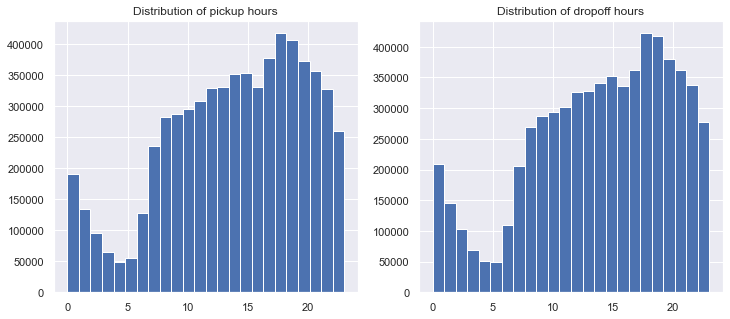

In [10]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,5))
df.pickup_hour.hist(bins=24,ax=ax[0])
ax[0].set_title('Distribution of pickup hours')
df.dropoff_hour.hist(bins=24,ax=ax[1])
ax[1].set_title('Distribution of dropoff hours')

The two distributions are almost similar, and most pickups and drops occur in the evening. While the least drops and pickups occur during morning.

In [11]:
df_pickup = df[['pickup_hour', 'pickup_zone', 'tip_amount']]
df_pickup

,pickup_hour,pickup_zone,tip_amount
0,0,Penn Station/Madison Sq West,0.00
1,0,Midtown Center,0.00
4,0,Forest Hills,0.00
5,0,Midtown Center,6.66
7,0,Kips Bay,2.36
...,...,...,...
6533693,23,Clinton East,0.00
6533694,23,Queensbridge/Ravenswood,0.00
6533695,23,Lincoln Square West,2.36
6533696,23,Upper West Side North,2.36


In [12]:
df_pickup[(df_pickup['pickup_zone'] == 'Arden Heights' )]

,pickup_hour,pickup_zone,tip_amount
24358,6,Arden Heights,0.0
117864,19,Arden Heights,0.0
236854,17,Arden Heights,0.0
302232,7,Arden Heights,0.0
572969,13,Arden Heights,0.0
765779,10,Arden Heights,0.0
1437397,7,Arden Heights,0.0
1513313,15,Arden Heights,0.0
1652464,11,Arden Heights,0.0
1822568,7,Arden Heights,0.0


In [13]:
df_pickup[(df_pickup['pickup_hour'] == 0)]

,pickup_hour,pickup_zone,tip_amount
0,0,Penn Station/Madison Sq West,0.00
1,0,Midtown Center,0.00
4,0,Forest Hills,0.00
5,0,Midtown Center,6.66
7,0,Kips Bay,2.36
...,...,...,...
6357982,0,JFK Airport,5.32
6358002,0,Times Sq/Theatre District,3.08
6358023,0,Flatiron,7.32
6358077,0,Midtown North,2.06


In [14]:
df_pickup[(df_pickup['pickup_zone'] == 'Arden Heights' ) &(df_pickup['pickup_hour'] == 0)]

,pickup_hour,pickup_zone,tip_amount


In [15]:

N_of_Trips = df_pickup.groupby(['pickup_hour','pickup_zone']).agg('count').unstack()
N_of_Trips.columns = N_of_Trips.columns.droplevel()
N_of_Trips

pickup_zone,Allerton/Pelham Gardens,Alphabet City,Arden Heights,Arrochar/Fort Wadsworth,Astoria,Astoria Park,Auburndale,Baisley Park,Bath Beach,Battery Park,...,Williamsbridge/Olinville,Williamsburg (North Side),Williamsburg (South Side),Windsor Terrace,Woodhaven,Woodlawn/Wakefield,Woodside,World Trade Center,Yorkville East,Yorkville West
pickup_hour,,,,,,,,,,,,,,,,,,,,,
0,1.0,766.0,NaN,NaN,343.0,4.0,1.0,62.0,NaN,27.0,...,6.0,644.0,415.0,6.0,2.0,NaN,80.0,843.0,431.0,2445.0
1,NaN,809.0,NaN,1.0,350.0,2.0,NaN,13.0,1.0,14.0,...,NaN,484.0,345.0,2.0,3.0,NaN,118.0,465.0,219.0,1602.0
2,NaN,724.0,NaN,NaN,291.0,NaN,NaN,9.0,NaN,5.0,...,1.0,370.0,337.0,2.0,NaN,NaN,105.0,240.0,159.0,1141.0
3,NaN,458.0,NaN,NaN,247.0,NaN,NaN,8.0,NaN,3.0,...,2.0,278.0,199.0,3.0,3.0,1.0,97.0,158.0,143.0,791.0
4,3.0,225.0,NaN,1.0,334.0,1.0,2.0,10.0,NaN,1.0,...,4.0,166.0,194.0,1.0,2.0,1.0,161.0,147.0,309.0,820.0
5,NaN,104.0,NaN,NaN,287.0,6.0,1.0,34.0,1.0,8.0,...,10.0,26.0,54.0,5.0,2.0,NaN,148.0,210.0,1008.0,1421.0
6,19.0,180.0,1.0,NaN,477.0,1.0,2.0,60.0,1.0,6.0,...,5.0,23.0,32.0,3.0,11.0,2.0,284.0,426.0,3191.0,3557.0
7,7.0,329.0,5.0,1.0,597.0,3.0,3.0,80.0,19.0,11.0,...,9.0,16.0,20.0,11.0,17.0,6.0,278.0,745.0,5929.0,5872.0
8,14.0,494.0,6.0,NaN,472.0,7.0,5.0,81.0,9.0,54.0,...,17.0,21.0,38.0,10.0,20.0,9.0,230.0,1143.0,6500.0,6865.0


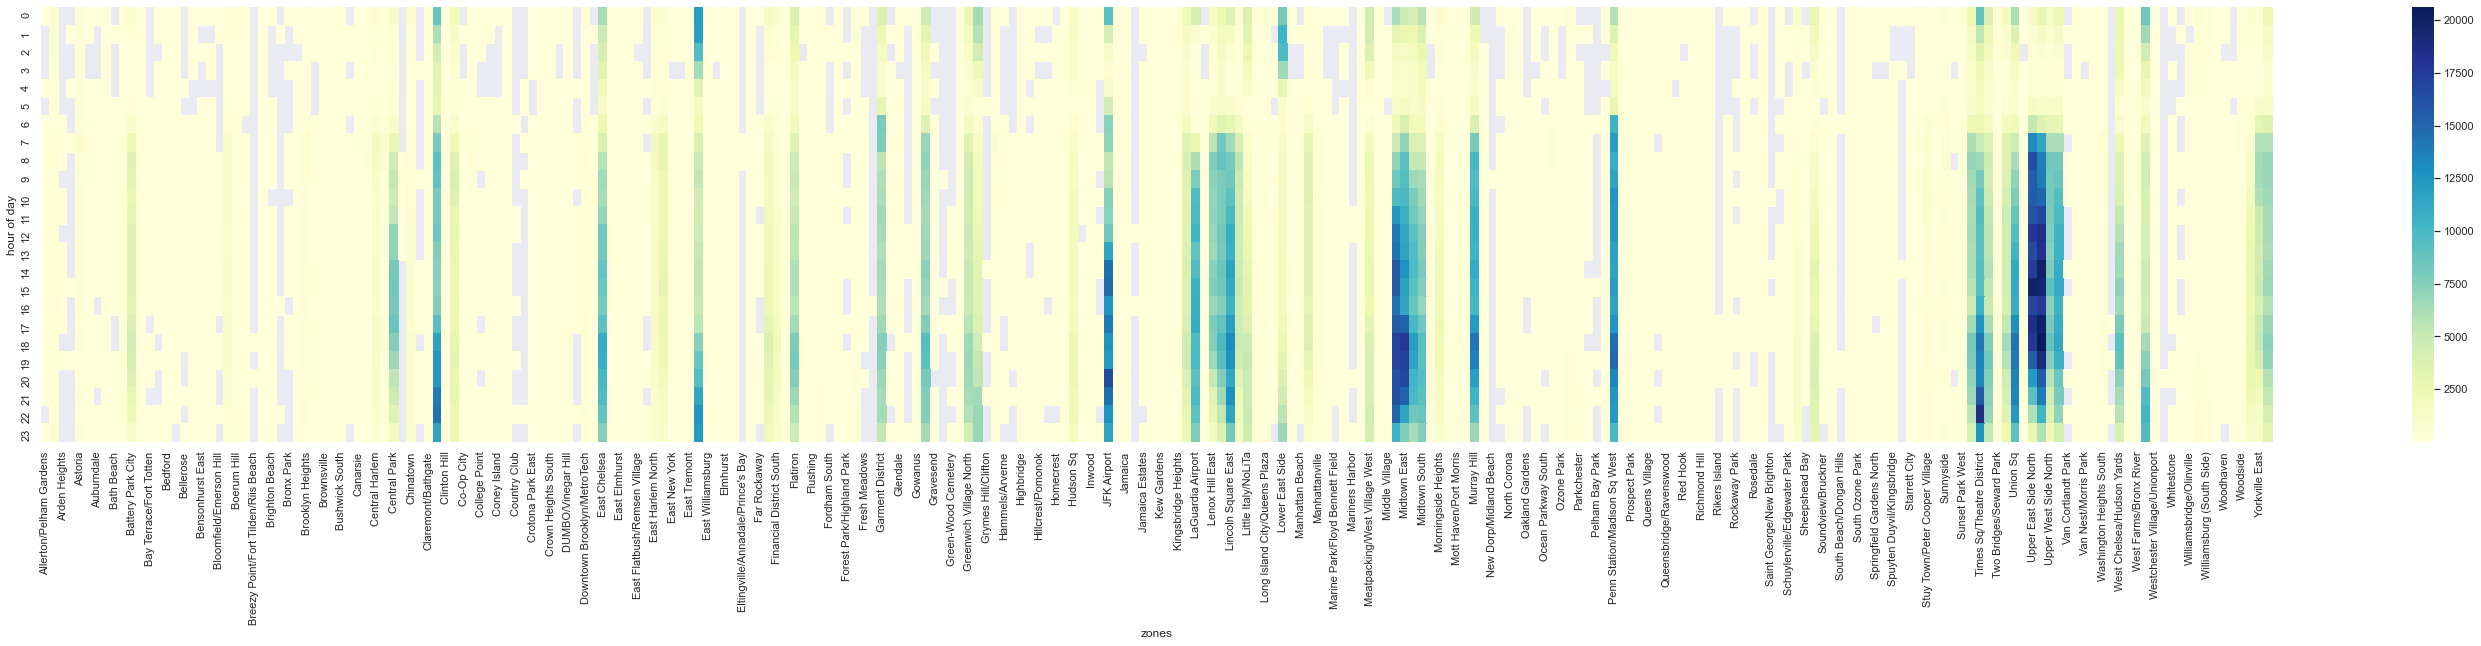

In [16]:
plt.figure(figsize = (50,8))
sns.heatmap(N_of_Trips, cmap="YlGnBu")
plt.xlabel('zones')
plt.ylabel('hour of day')
plt.show()

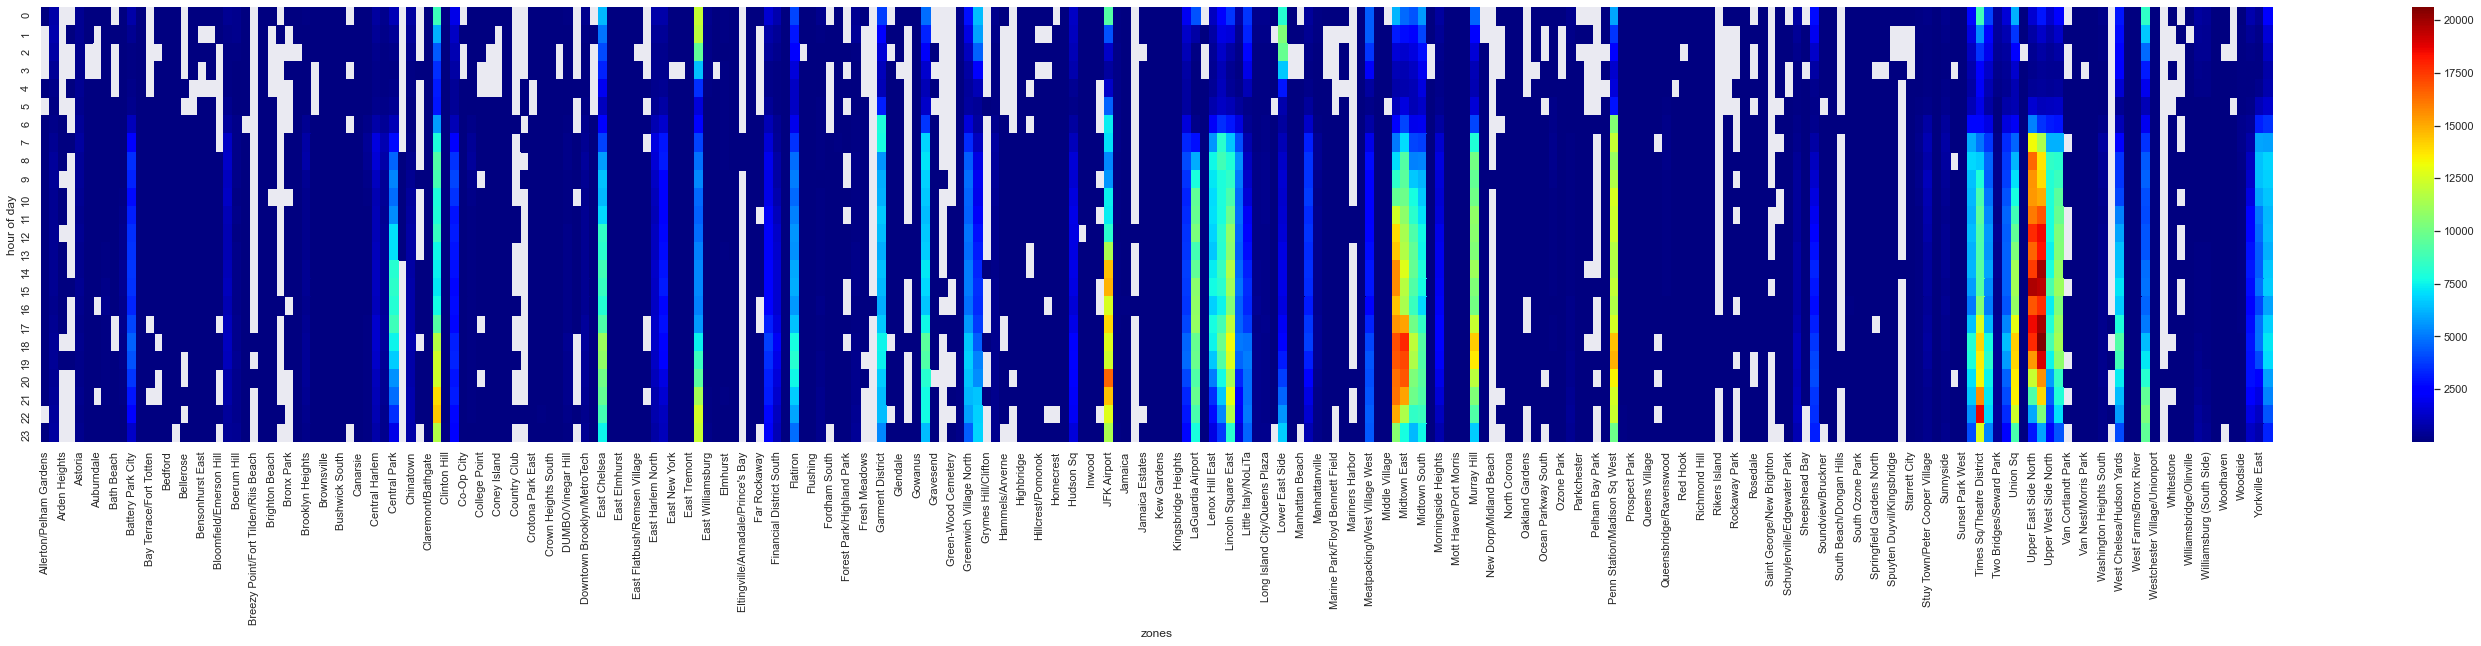

In [17]:
plt.figure(figsize = (50,8))
sns.heatmap(N_of_Trips, cmap="jet")
plt.xlabel('zones')
plt.ylabel('hour of day')
plt.show()

### Histogram of the Trip Distance

The average distance is 3.0 , the standard deviation is 3.8
The median distance is 1.7 , the 95% of trips distance fell between 0.4 to 17.1


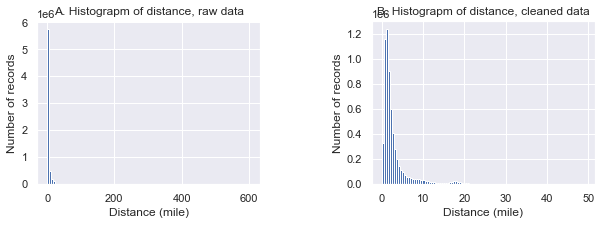

In [18]:
# plot distance with and without data cleaning
fig, axs = plt.subplots(1,2)
fig.set_size_inches(10, 3)
fig.subplots_adjust(wspace=.5)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(df_orig['trip_distance'],bins=100);
axs[0].set_title('A. Histograpm of distance, raw data')
axs[0].set_xlabel('Distance (mile)')
axs[0].set_ylabel('Number of records')

axs[1].hist(df['trip_distance'],bins=100);
axs[1].set_title('B. Histograpm of distance, cleaned data')
axs[1].set_xlabel('Distance (mile)')
axs[1].set_ylabel('Number of records');

#fig.savefig('fig2.svg', format='svg',dpi=400, bbox_inches='tight')

print('The average distance is',round(df['trip_distance'].mean(),1),', the standard deviation is',round(df['trip_distance'].std(),1))
print('The median distance is',round(df['trip_distance'].median(),1),', the 95% of trips distance fell between',
      round(df['trip_distance'].quantile(.025),2),'to',round(df['trip_distance'].quantile(.975), 1))

The distribution of trip distance in the raw data is extremely right skewed, with most data clumped at the lower range and a few records of implausibly large values. After data selection, the right skewness lessened. In the analytical dataset, the mean distance was 3.0 miles, with a standard deviation of 3.83 miles. The median distance was 1.4 miles, and most of trips traveled between 1-5 miles. Since distance is highly right-skewed, the median distance is a better measure of the central tendency of the distribution of distance.

#### Mean and median trip distance grouped by hour of day

In [19]:
df_hourly_distance=df[['trip_distance','pickup_hour']].groupby(by='pickup_hour').mean()
df_hourly_distance.columns=['mean_trip_distance']
df_hourly_distance['medium_trip_distance']=df[['trip_distance','pickup_hour']].groupby(by='pickup_hour').median()
print(df_hourly_distance)

             mean_trip_distance  medium_trip_distance
pickup_hour                                          
0                      3.519774                  2.10
1                      3.236778                  2.07
2                      3.073169                  2.07
3                      3.309820                  2.16
4                      4.454127                  2.70
5                      4.881317                  2.30
6                      3.637023                  1.80
7                      2.975464                  1.66
8                      2.715097                  1.56
9                      2.688400                  1.52
10                     2.775593                  1.55
11                     2.801867                  1.54
12                     2.826192                  1.50
13                     3.033277                  1.55
14                     3.148887                  1.58
15                     3.123979                  1.59
16                     3.029

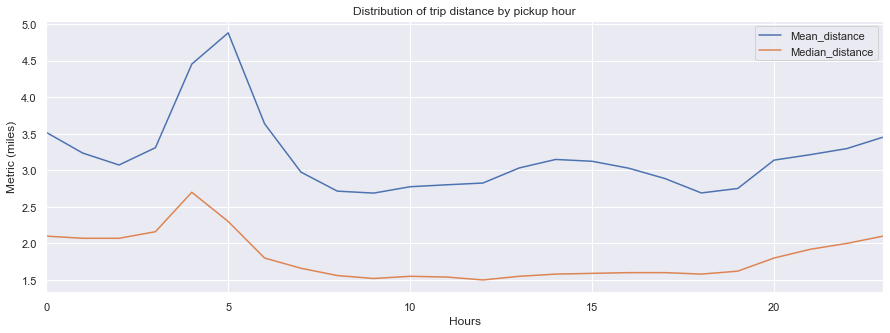

In [20]:
fig,ax = plt.subplots(1,1,figsize=(15,5)) # prepare fig to plot mean and median values
# use a pivot table to aggregate Trip_distance by hour
table1 = df.pivot_table(index='pickup_hour', values='trip_distance',aggfunc=('mean','median')).reset_index()
# rename columns
table1.columns = ['Hour','Mean_distance','Median_distance']
table1[['Mean_distance','Median_distance']].plot(ax=ax)
plt.ylabel('Metric (miles)')
plt.xlabel('Hours')
plt.title('Distribution of trip distance by pickup hour')
plt.xlim([0,23])
plt.savefig('Distribution_of_trip_distance_by_pickup_hour.jpeg',format='jpeg')
plt.show()

Mean distances were constantly higher than median distance during each hour. This is most likely because the distribution of trip distance is right-skewed, and the mean could be inflated by a few long-distance trips. As such, the median is a fairer representation of the central tendency of all distances.

### airport trips to calculate number of trips and median fare

In [21]:
# To define airport trips:
## rate code = 2 or 3
## pickup or dropoff location in JFK, LGA, or EWR
trip_air = (df['RatecodeID'].isin([2,3]))| (df['pickup_boro'].isin(['JFK','LGA','EWR'])) | (df['dropoff_boro'].isin(['JFK','LGA','EWR']))

#calculate airport and non airport trips number
df['airport_trip'] = 'nonairport'
df['airport_trip'].loc[trip_air] = 'airport'
print('There are', df['airport_trip'].value_counts()[0],'non-airport trips and',df['airport_trip'].value_counts()[1],'airport trips.')
print('The median fare without tips of all airport trips is $',df.groupby(by=['airport_trip']).median()['fare_amount'][0])
print('The median fare with tips of all airport trips is $',df.groupby(by=['airport_trip']).median()['total_amount'][0])

/Users/zora/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


There are 5810418 non-airport trips and 527389 airport trips.
The median fare without tips of all airport trips is $ 40.5
The median fare with tips of all airport trips is $ 53.8


In [22]:
# calcuate median and standard deviation for airport trips and non-airport trips
airport_fare = df[['total_amount','airport_trip']].groupby(by=['airport_trip']).median()
airport_fare.columns = ['median_total_amount']
airport_fare['standard_deviation'] = df[['total_amount','airport_trip']].groupby(by=['airport_trip']).std()
airport_fare

,median_total_amount,standard_deviation
airport_trip,,
airport,53.8,20.122148
nonairport,14.3,7.728908


Let's have look at how trips are distributed by trip distances and hour of the day

/Users/zora/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':
/Users/zora/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  del sys.path[0]
/Users/zora/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarn

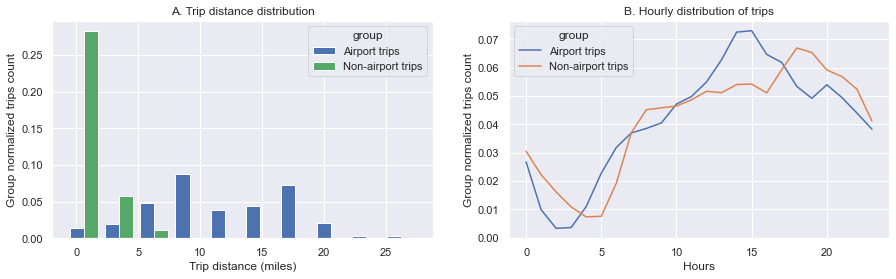

In [23]:
# create a vector to contain Trip Distance for
v2 = df[df['airport_trip']=='airport'].trip_distance# airport trips
v3 = df[df['airport_trip']=='nonairport'].trip_distance # non-airport trips

# remove outliers: 
# exclude any data point located further than 3 standard deviations of the median point and 
# plot the histogram with 30 bins
v2 = v2[~((v2-v2.median()).abs()>3*v2.std())]
v3 = v3[~((v3-v3.median()).abs()>3*v3.std())] 

# define bins boundaries
bins = np.histogram(v2,normed=True)[1]
h2 = np.histogram(v2,bins=bins,normed=True)
h3 = np.histogram(v3,bins=bins,normed=True)

# plot distributions of trip distance normalized among groups
fig,ax = plt.subplots(1,2,figsize = (15,4))
w = .4*(bins[1]-bins[0])
ax[0].bar(bins[:-1],h2[0],alpha=1,width=w,color='b')
ax[0].bar(bins[:-1]+w,h3[0],alpha=1,width=w,color='g')
ax[0].legend(['Airport trips','Non-airport trips'],loc='best',title='group')
ax[0].set_xlabel('Trip distance (miles)')
ax[0].set_ylabel('Group normalized trips count')
ax[0].set_title('A. Trip distance distribution')
#ax[0].set_yscale('log')

# plot hourly distribution
df[df['airport_trip']=='airport'].pickup_hour.value_counts(normalize=True).sort_index().plot(ax=ax[1])
df.loc[~df.index.isin(v2.index),'pickup_hour'].value_counts(normalize=True).sort_index().plot(ax=ax[1])
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Group normalized trips count')
ax[1].set_title('B. Hourly distribution of trips')
ax[1].legend(['Airport trips','Non-airport trips'],loc='best',title='group')
plt.savefig('QHourly_distribution_of_trips.jpeg',format='jpeg')
plt.show()

Text(0.5, 1.0, 'Histogram')

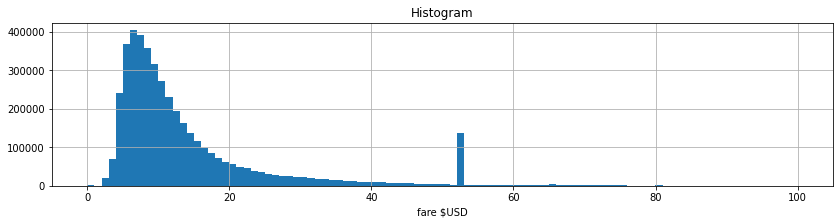

In [29]:
# plot histogram of fare
df[df.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram')

In the histogram of the fare_amount there are some small spikes between 40 USD and 60 USD. This could indicate some fixed fare price (e.g. to/from airport). This will be explored further below.

## General Questions

Q : Busiest/least busy hours in a day? 

Q : maxi, min, and average pickup per minute?

Q : Difference between weekdays and weekends?

Q : Busiest/least busy day in the week? Correlation to other weeks?

Q : Busiest/least busy day in the month?

Q : Average speed per mile?

Q : Average price per mile?

Q : Highest and lowest (of previous two questions) in a day?

Q : Any difference between weekdays and weekends?

In [24]:
no_tip = df[df['tip_amount'] == 0]['tip_amount'].count()
no_tip

1883126

In [25]:
events_per_minute = (df.iloc[:, 0].groupby(by=[df["tpep_pickup_datetime"].dt.day, df["tpep_pickup_datetime"]
                     .dt.hour]).count()/ 60)
events_per_minute.describe()

count    720.000000
mean     146.708495
std       72.549372
min        9.150000
25%       87.358333
50%      172.408333
75%      199.083333
max      309.466667
Name: VendorID, dtype: float64

Text(0.5, 1.0, 'Events per Minute')

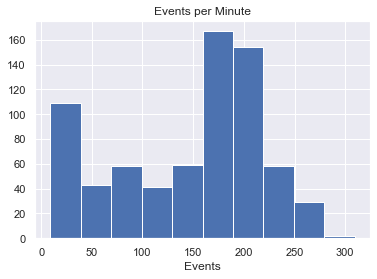

In [26]:
events_per_minute.hist()
plt.xlabel('Events')
plt.title('Events per Minute')

#### On average, there are more than 100 events per minute.

In [29]:
events_per_second = df["tpep_pickup_datetime"].dt.hour.count()/ 60/ 60
events_per_second

1760.5019444444445

In [28]:
df["tpep_pickup_datetime"].dt.day.count()

6337807